                                                 Предобработка данных 


In [2]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.tree import export_graphviz
from IPython.display import Image, display
import pydotplus

In [3]:
# Зададим размер графиков по умолчанию
sns.set(rc={'figure.figsize':(9,6)})

In [4]:
# Загрузим датасеты
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [5]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [6]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


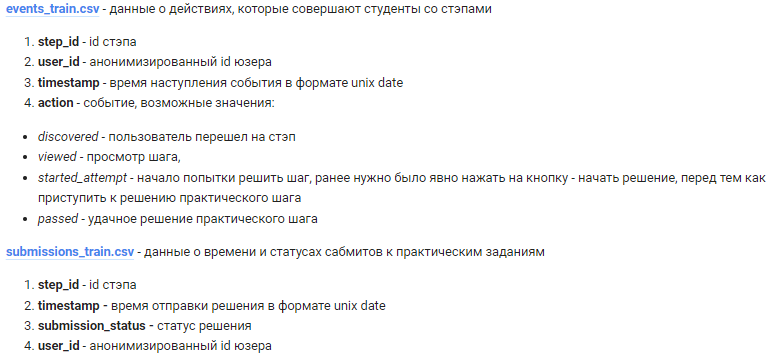

In [8]:
# Переведем формат времени из unix в обычный, timestamp указан в секундах (отсчет с 1970)
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [9]:
# Создадим столбец просто с датой, без времени
submissions_data['day'] = submissions_data.date.dt.date
events_data['day'] = events_data.date.dt.date

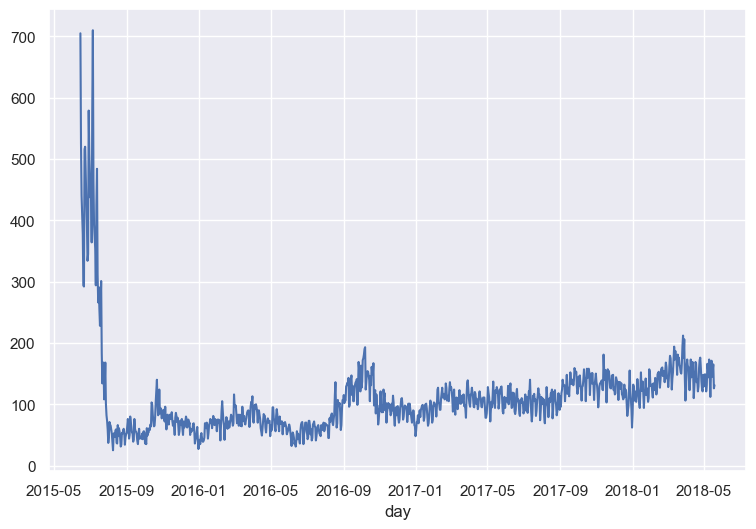

In [10]:
# Посмотрим, сколько у нас было уникальных пользователей на дню
events_data.groupby('day')  \
            .user_id.nunique().plot()
plt.show()

In [11]:
# Посчитаем кол-во совершенных событий
user_events_data = events_data.pivot_table(index='user_id', 
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()

In [12]:
user_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [13]:
# Посчитаем кол-во решенных заданий
users_scores = submissions_data.pivot_table(index='user_id',
                            columns='submission_status',
                            values='step_id',
                            aggfunc='count',
                            fill_value=0).reset_index()

In [14]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [15]:
# Задача заключается в том, чтобы предсказывать людей, которые дропнуться с курса
# Но как понять, ели человек не заходил неделю, он бросил курс?
# Или не заходил месяц? Применим статистические методы для определения этого порога с заданной вероятностью

In [16]:
# Теперь отберем данные для юзеров по дням, в которых они сделали хотябы одно действие, а значит все действия за день нам не нужны
# Лишние удалим (дубликаты по колонкам 'user_id', 'day')
# Рассчитаем разницу по дням (промежуток в днях между занятиями)

In [17]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']). \
            groupby('user_id')['timestamp'].apply(list). \
            apply(np.diff).values

In [18]:
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

In [19]:
# Теперь объединим все по строкам и обернем в серию
gap_data = pd.Series(np.concatenate(gap_data, axis=0))
gap_data = gap_data / (24 * 60 * 60) # Разделили на часы, минуты и секунды, рузультат в днях

In [20]:
gap_data.head()

0    56.060208
1    79.852419
2     2.112083
3     1.084606
4    32.047106
dtype: float64

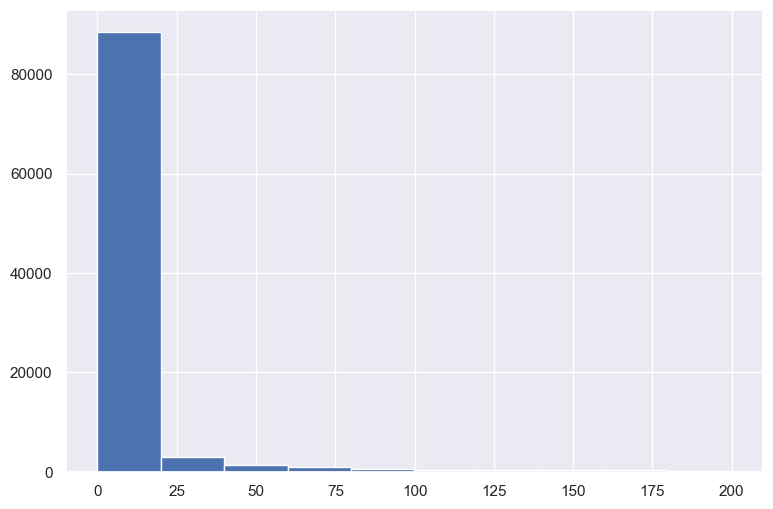

In [21]:
gap_data[gap_data < 200].hist()
plt.show()

In [22]:
# Теперь определим 95 процентиль
gap_data.quantile(0.95).round(1)

59.8

In [23]:
 # Если немного ослабить порог
gap_data.quantile(0.90).round(1)

18.3

In [24]:
#  В среднем возьмем число 30 - т.е. если человек не заходил более 30 дней, то считаем, что он покинул курс безвозвратно

In [25]:
# Расчитаем для каждого юзера время его последнего появления на курсе

In [26]:
user_data = events_data.groupby('user_id', as_index=False).  \
            aggregate({'timestamp': 'max'}).  \
            rename(columns={'timestamp': 'last_timestamp'})

In [27]:
user_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [28]:
# Теперь определим, сколько дней прошло от последнего захода до последнего timestamp=1526772811 (якобы это сейчас 2018-05-19)

In [29]:
now = 1526772811  # Настоящее время
drop_out_threshold = 30 * 24 * 60 * 60  # 30 дней в секундах, наше пороговое значение

In [30]:
# Пользователи, отсутствовавшие более 30 дней (включая тех, кто прошел курс)
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_threshold

In [31]:
# Объединим таблицы, т.е. добавим данные о том, сколько он решили заданий и сколько было попыток
user_data = user_data.merge(users_scores, on='user_id', how='outer')
# how='outer' - чтобы не потерять непересекающиеся данные

In [32]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [33]:
# Заменим NaN на 0
user_data = user_data.fillna(0)

In [34]:
# Добавим данные о степах
user_data = user_data.merge(user_events_data, on='user_id', how='outer')

In [35]:
# Добавим данные о количестве дней, в которые юзеры выполняли задания
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [36]:
user_data = user_data.merge(users_days, on='user_id', how='outer')

In [37]:
# Добавим еще колонку, прошол ли курс юзер (набрал больше 170 баллов)
user_data['passed_course'] = user_data.passed > 170

In [38]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [39]:
# Посмотрим кол-во дней прохождения курса теми, кто его завершил или бросил

In [40]:
# Медианное значение
user_data[user_data.passed_course == True].day.median()

20.0

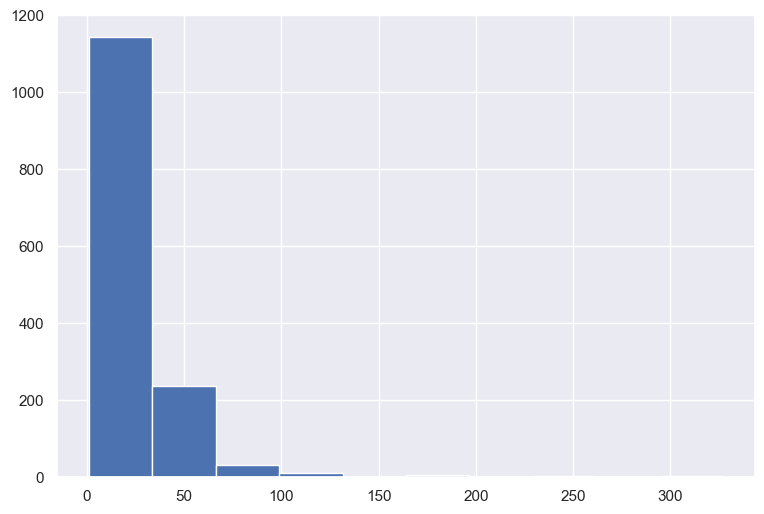

In [41]:
# Распределение дней
user_data[user_data.passed_course == True].day.hist()
plt.show()

In [42]:
# Половина людей решили курс за 20 ней и быстрее.

In [43]:
# Время, когда человек сделал первое действие на сайте
user_min_time = events_data.groupby('user_id', as_index=False) \
                            .aggregate({'timestamp': 'min'}) \
                            .rename({'timestamp': 'min_timestamp'}, axis=1)

In [44]:
user_data = user_data.merge(user_min_time, how='outer')

In [45]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [46]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [47]:
# Извлечем строки с пользователями за первые три дня с момента начала их обучения

In [48]:
# Создадим новый столбец
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [49]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


In [50]:
#Примем начальный интервал для предсказания "бросит, не бросит" в 7 дней
leatning_time_threshold = 7 * 24 * 60 * 60

In [51]:
# Переменная с конечным временем отсчета (через 7 дней)
user_leatning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + leatning_time_threshold).map(str)

In [52]:
user_leatning_time_threshold.head()

0    1_1473432264
1    2_1514988164
2    3_1434963276
3    5_1466761609
4    7_1522239460
dtype: object

In [53]:
user_min_time['user_leatning_time_threshold'] = user_leatning_time_threshold

In [54]:
events_data = events_data.merge(user_min_time[['user_id', 'user_leatning_time_threshold']], how='outer')

In [55]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_leatning_time_threshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473432264
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473432264
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514988164
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514988164
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514988164


In [56]:
# Теперь, когда мы создали столбец с граничными значениями по времени (7 дней), осталось только отфильтровать все user_time
# и оставить только те, которые меньше порогового значения

In [57]:
events_data_train = events_data[events_data.user_time <= events_data.user_leatning_time_threshold]

In [58]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_leatning_time_threshold
0,31981,1472827464,viewed,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473432264
1,31981,1472827464,discovered,1,2016-09-02 14:44:24,2016-09-02,1_1472827464,1_1473432264
2,32815,1514383364,discovered,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514988164
3,32815,1514383364,viewed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514988164
4,32815,1514383364,passed,2,2017-12-27 14:02:44,2017-12-27,2_1514383364,2_1514988164


In [59]:
# Сделаем тоже самое (отберем строки с 7 днями занятий от начала) для submissions_data

In [60]:
# Объединим строки id и времени
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)

# Добавим столбец с конечным временем отсчета (через 7 дней)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_leatning_time_threshold']], how='outer')

# Отфильтруем только те строки, которые входят в наш интервал времени (в 7 дней)
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_leatning_time_threshold]

# Проверяем количество уникальных дней
submissions_data_train.groupby('user_id').day.nunique().max()

8

In [61]:
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_leatning_time_threshold
1,32812.0,1.514383e+09,correct,2,2017-12-27 14:04:45,2017-12-27,2_1514383485,2_1514988164
2,32929.0,1.514383e+09,correct,2,2017-12-27 14:03:40,2017-12-27,2_1514383420,2_1514988164
6,31977.0,1.434359e+09,wrong,3,2015-06-15 09:10:32,2015-06-15,3_1434359432,3_1434963276
7,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:00,2015-06-15,3_1434359520,3_1434963276
8,31977.0,1.434360e+09,wrong,3,2015-06-15 09:12:21,2015-06-15,3_1434359541,3_1434963276


In [62]:
# Переменная с данными о количестве дней, в которые человек занимался за наш период (7 дней)
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index() \
    .rename(columns={'day': 'days'})

In [63]:
# Сколько уникальных степов человек попытался решить за первые 7 дней
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
                .rename(columns={'step_id': 'steps_tried'})

In [64]:
# Объединим
X = X.merge(steps_tried, on='user_id', how='outer')

In [65]:
# Отберем данные по количеству правильных и неправильных попыток
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                                  columns='submission_status',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index())

In [66]:
# Для упрощения выявления паттернов добавим колонку с процентом верных решений
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [67]:
# Добавим колонку, сколько суммарно было просмотрено степов
X = X.merge(events_data_train.pivot_table(index='user_id', 
                                  columns='action',
                                  values='step_id',
                                  aggfunc='count',
                                  fill_value=0).reset_index()[['user_id', 'viewed']], how='outer')

In [68]:
X = X.fillna(0)

In [69]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,1,0.0,0.0,0.0,0.0,0.0,1
1,2,1.0,2.0,2.0,0.0,1.0,9
2,3,1.0,4.0,4.0,4.0,0.5,20
3,5,0.0,0.0,0.0,0.0,0.0,1
4,7,0.0,0.0,0.0,0.0,0.0,1


In [70]:
X = X.merge(user_data[['user_id', 'passed_course', 'is_gone_user']], how='outer')

In [71]:
# Отберем тех, кто прошел курс или его уже бросил (~ - знак отрицания)
X = X[~((X.is_gone_user == False) & (X.passed_course == False))]

In [72]:
# Заменим индекс на колонку user_id
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)


In [73]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
user_id,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,1,False,True
2,1.0,2.0,2.0,0.0,1.0,9,False,True
3,1.0,4.0,4.0,4.0,0.5,20,False,True
5,0.0,0.0,0.0,0.0,0.0,1,False,True
7,0.0,0.0,0.0,0.0,0.0,1,False,True


In [74]:
y = pd.DataFrame(X['passed_course'].map(int), index=X.index)

In [75]:
y.head()

,passed_course
user_id,
1,0
2,0
3,0
5,0
7,0


In [76]:
X = X.drop(['passed_course', 'is_gone_user'], axis=1)


                                            Решение с помощью DecisionTreeClassifier
                                                      

In [78]:
# Создаем модель
clf = tree.DecisionTreeClassifier(criterion='entropy')

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [80]:
# Создаем тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
# Зададим параметры для классификатора
parametrs = {'criterion': ['gini', 'entropy'], 'max_depth':  range(1, 30)}

In [82]:
# Создадим переменную для подбора параметров
grid_search_cv_clf = GridSearchCV(clf, parametrs, cv=5)

In [83]:
# Подберем оптимальные параметры с помощью кросс-валлидации, при этом обучим модель
grid_search_cv_clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(criterion='entropy'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [84]:
best_clf = grid_search_cv_clf.best_estimator_

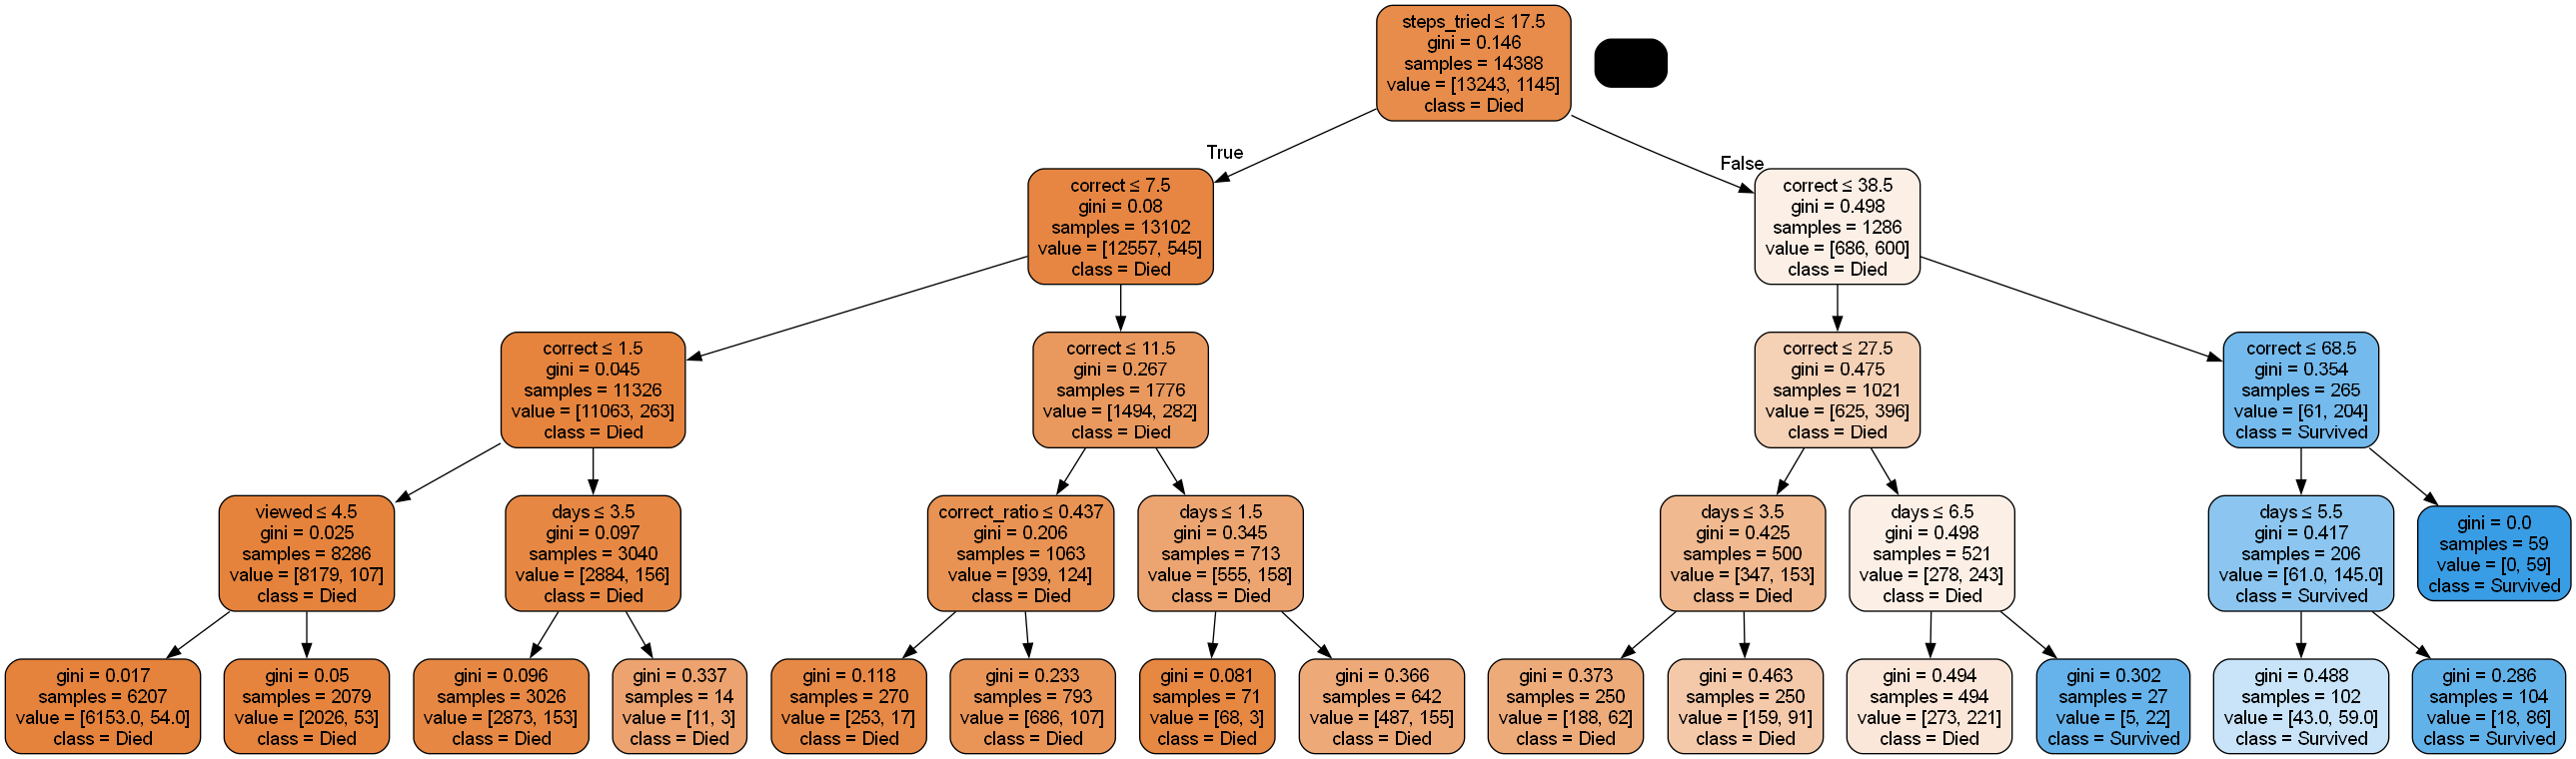

In [85]:
dot_data = export_graphviz(best_clf, out_file=None, 
                           feature_names=list(X),  
                           class_names=['Died', 'Survived'],  
                           filled=True, rounded=True,  
                           special_characters=True)    

graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

In [86]:
# Точность модели
round(best_clf.score(X_test, y_test), 2)

0.93

In [87]:
# Рассчитаем параметры точности(precision) и полноты(recall)
from sklearn.metrics import precision_score, recall_score, f1_score

In [88]:
# Предсказанные значения
y_pred = best_clf.predict(X_test)

In [89]:
precision_tree = round(precision_score(y_test, y_pred), 2)
precision_tree

0.66

In [90]:
recall_tree = round(recall_score(y_test, y_pred), 2)
recall_tree

0.18

In [91]:
f1_tree =  round(f1_score(y_test, y_pred), 2)
f1_tree

0.29


                                        Решение через логистическую регрессию
                                                 (ручная реализация)
                                                         

In [93]:
# Переменная X. Удалим столбец "correct_ratio", т.к. он связан со столбцами "correct" и "wrong" (мультиколлинеарность)  
X_log = X_train.drop("correct_ratio", axis=1)

In [94]:
X_log.head()

,days,steps_tried,correct,wrong,viewed
user_id,,,,,
21115,3.0,7.0,8.0,8.0,51
12320,0.0,0.0,0.0,0.0,2
12715,0.0,0.0,0.0,0.0,3
12445,4.0,28.0,28.0,42.0,162
16434,0.0,0.0,0.0,0.0,1


In [95]:
from sklearn.preprocessing import MinMaxScaler

In [96]:
# Избавимся от выбросов (меньше 1%)
for i in range(len(X_log.columns)):
    upper_limit = X_log.iloc[:, i].quantile(0.99)  # Находим 99-й перцентиль
    X_log.iloc[:, i] = np.where(X_log.iloc[:, i] > upper_limit, upper_limit, X_log.iloc[:, i])  # Удаляем выбросы

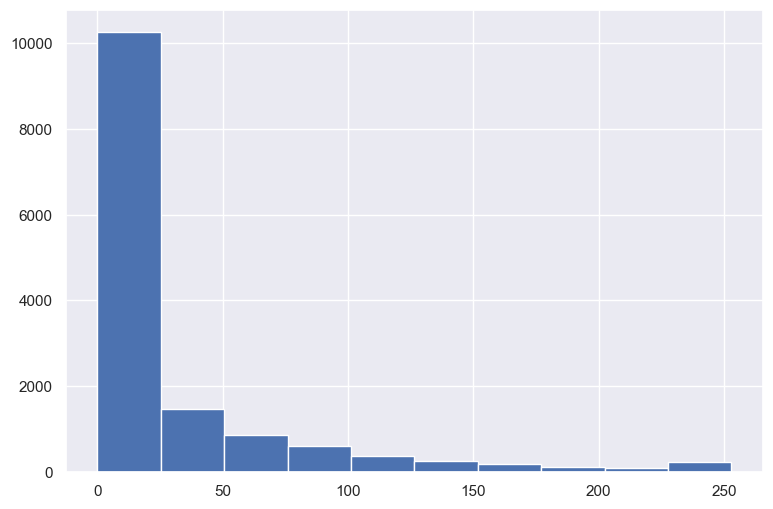

In [97]:
X_log.viewed.hist()
plt.show()

In [98]:
# Данные имеют экспоненциальное распределение
# Стандартизируем (масштабируем) данные по методу MinMaxS (от 0 до 1)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_log), columns=X_log.columns, index=X_log.index)

In [99]:
X_scaled.head()

,days,steps_tried,correct,wrong,viewed
user_id,,,,,
21115,0.500000,0.14,0.163265,0.109394,0.201581
12320,0.000000,0.00,0.000000,0.000000,0.007905
12715,0.000000,0.00,0.000000,0.000000,0.011858
12445,0.666667,0.56,0.571429,0.574320,0.640316
16434,0.000000,0.00,0.000000,0.000000,0.003953


In [100]:
from random import randint, seed

In [101]:
# 1) Создадим массив с рандомными значениями весов (их на 1 больше чем параметров, т.к. есть еще и W0)
seed(20)  # Начальное смещение для обеспечения повторяемости результата
weights = [randint(-100, 100) / 100 for i in range(len(X_scaled.columns) + 1)]

In [102]:
weights

[0.85, 0.75, 0.96, -0.62, -0.34, 0.72]

In [103]:
# 2) Расчитываем целевой показатель (у)
def z_func(x_1, wey_1):
    z = pd.DataFrame((x_1 * wey_1[:-1]).sum(axis=1), columns=['summ']) + wey_1[-1]
    return z

def fi_z(z_1):
    return 1 / (1 + np.e ** (-z_1))
    

In [104]:
# Функция логистической ошибки
def logistic_error(o, t):
    # Избавимся от значений 0 и 1, чтобы не возникало ошибок при расчете логарифма
    o_ad = o.iloc[:, 0].apply(lambda x: 0.00001 if x == 0 else (0.99999 if x == 1 else x))
    L = -(t.iloc[:, 0] * np.log(o_ad) - (1 - t.iloc[:, 0]) * np.log(1 - o_ad)).sum() / len(t)
    return L

In [105]:
# 3) При помощи градиентного спуска минимизируем функцию логистической ошибки
learning_rate = 0.1
for i in range(100):
    z = z_func(X_scaled, weights)
    fi = fi_z(z)
    # print(i, logistic_error(fi, y_train))
    for j in range(len(weights) - 1):
        weights[j] -= (learning_rate * X_scaled.iloc[:, j] * (fi.iloc[:, 0] - y_train.iloc[:, 0]) / len(y_train)).sum()  # 0.1 - скорость обучения
    weights[-1] -= (learning_rate * (fi.iloc[:, 0] - y_train.iloc[:, 0]) / len(y_train)).sum() 
    

In [106]:
round(logistic_error(fi, y_train), 3)

-0.046

In [107]:
best_weights = weights
best_weights

[0.631993021664419,
 0.6673359751220326,
 0.8780301883984702,
 -0.661572195698888,
 -0.4707028485749111,
 -1.7884409267311392]

In [108]:
# Подберем оптимальное пороговое значение (threshold) через ROC кривую
z_0 = z_func(X_scaled, best_weights)
fi_0 = fi_z(z)

In [109]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

In [110]:
fpr, tpr, thresholds = roc_curve(y_train, fi_0)
auc_score = roc_auc_score(y_train, fi_0)

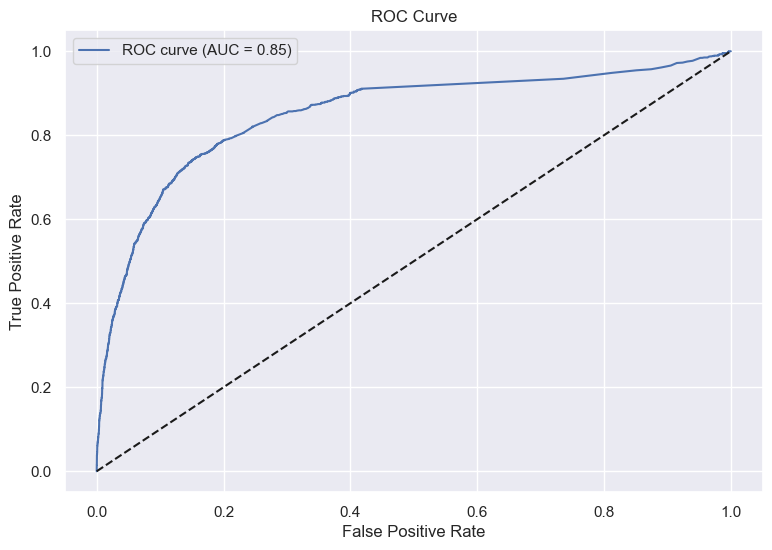

In [111]:
# Построим ROC-кривую
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Линия случайного классификатора
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [112]:
# Оптимальное пороговое значение
f1_scores = []
for thresh in thresholds:
    y_pred = (fi_0 >= thresh).astype(int)
    f1 = f1_score(y_train, y_pred)
    f1_scores.append(f1)

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог (max F1-score): {optimal_threshold:.2f}")

Оптимальный порог (max F1-score): 0.22


In [113]:
# Тестовые данные
X_test_2 = X_test.drop("correct_ratio", axis=1)

In [114]:
# Тестирование модели, предсказание
def y_pred_log(X, weight, threshold):
   
    X_scaled_2 = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)   # Стандартизируем данные
    
    z = z_func(X_scaled_2, weight)
    fi = fi_z(z)
  
    y_pred_2 = fi.iloc[:, 0].apply(lambda x: 0 if x < threshold else 1)
    
    return y_pred_2

In [115]:
y_pred_2 = y_pred_log(X_test_2, best_weights, optimal_threshold)

In [116]:
precision_log = round(precision_score(y_test, y_pred_2), 2)
precision_log

0.43

In [117]:
recall_log = round(recall_score(y_test, y_pred_2), 2)
recall_log

0.5

In [118]:
f1_log =  round(f1_score(y_test, y_pred_2), 2)
f1_log

0.46


                                        Решение через логистическую регрессию
                                                     (sklearn)


In [120]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [121]:
X_scaled.head()

,days,steps_tried,correct,wrong,viewed
user_id,,,,,
21115,0.500000,0.14,0.163265,0.109394,0.201581
12320,0.000000,0.00,0.000000,0.000000,0.007905
12715,0.000000,0.00,0.000000,0.000000,0.011858
12445,0.666667,0.56,0.571429,0.574320,0.640316
16434,0.000000,0.00,0.000000,0.000000,0.003953


In [122]:
#Создаем модель логистической регрессии
model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')  

In [123]:
# Обучаем ее
model.fit(X_scaled, y_train.iloc[:, 0])

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [124]:
# Предсказание 
y_pred_3 = model.predict(X_test_2)

In [125]:
precision_log_sklearn = round(precision_score(y_test, y_pred_3), 2)
precision_log_sklearn

0.12

In [126]:
recall_log_sklearn = round(recall_score(y_test, y_pred_3), 2)
recall_log_sklearn

0.94

In [127]:
f1_log_sklearn =  round(f1_score(y_test, y_pred_3), 2)
f1_log_sklearn

0.21